# Exercise on multiple Markov chains (MMC)

In [301]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
from statsmodels.tsa.stattools import acf

# paths for saving images in report
########################################
report_path = "/home/nunziato-damino/Documents/Github/NMSM_2024/Block 1/Report"
file_path = "/home/nunziato-damino/Documents/Github/NMSM_2024/Block 1/Exercise_6"
exercise_folder = "FIG/exercise_5_images"
########################################


In [302]:
# Parameters
c = 1 
monomer_radius = c / 2
x_initial,y_initial = (0, 0)
bond_length_min, bond_length_max = (1, 1.3)
n_monomers = 20
epsilon_energy = 1
energy_threshold = 0.5

## Geometry

In [303]:
#initial configuration (vertical stick)
monomers_initial_conf=np.zeros((n_monomers,2))
bond = 1.15
for i in range (1, n_monomers):
    monomers_initial_conf[i][1]=i*bond*c

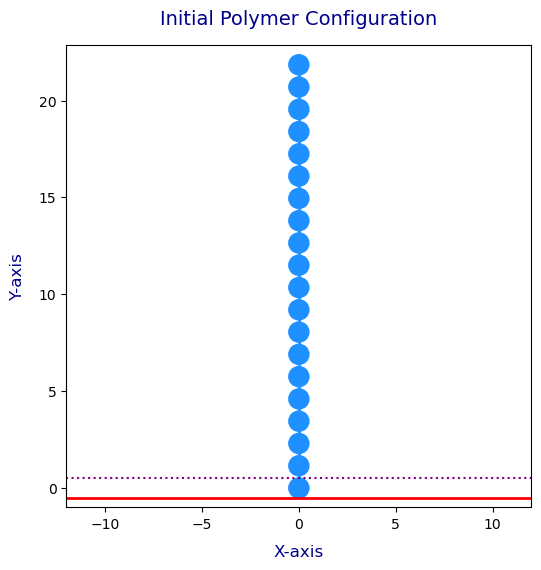

In [304]:
# Initial configuration plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='datalim')

for i, point in enumerate(monomers_initial_conf):
    circle = plt.Circle((point[0], point[1]), 0.5, color='dodgerblue', alpha=1,linewidth=1.5)
    ax.add_patch(circle)
    if i > 0:
        prev_point = monomers_initial_conf[i - 1]
        ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='dodgerblue', linewidth=2)

ax.set_xlim(min(p[0] for p in monomers_initial_conf) - 1, max(p[0] for p in monomers_initial_conf) + 1)
ax.set_ylim(min(p[1] for p in monomers_initial_conf) - 1, max(p[1] for p in monomers_initial_conf) + 1)
ax.axhline(y=-monomer_radius, color='red', linestyle='-', linewidth=2, label="Wall")
ax.axhline(y=energy_threshold, color='purple', linestyle=':', linewidth=1.5, label="Energy Threshold")
ax.set_xlabel("X-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_ylabel("Y-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_title("Initial Polymer Configuration", fontsize=14, color='darkblue', pad=15)

plt.show()

In [305]:
@numba.njit
def polymer_displacement(configuration):
    sigma = monomer_radius / 8
    shift_conf = np.zeros((n_monomers,2))
    valid_configuration = False
    # ---- Move generation
    while (not valid_configuration): # Local shifts move
        for i in range(1,n_monomers):
            shift_conf[i][0]=configuration[i][0] + np.random.normal(0, sigma)
            shift_conf[i][1]=configuration[i][1] + np.random.normal(0, sigma)
        MAX_ANGLE = np.pi / 6 # Pivot rotation move
        angle = np.random.uniform(-MAX_ANGLE, MAX_ANGLE)
        pivot = np.random.randint(0, n_monomers)  # Ensure pivot is an integer index
        new_conf = shift_conf   
        for i in range(pivot, n_monomers): # Apply rotation around the pivot point
            dx = shift_conf[i][0] - shift_conf[pivot][0]
            dy = shift_conf[i][1] - shift_conf[pivot][1]
            new_conf[i] = (
                dx * np.cos(angle) - dy * np.sin(angle) + shift_conf[pivot][0],
                dx * np.sin(angle) + dy * np.cos(angle) + shift_conf[pivot][1]
            )
    # ----- Geometry constraints
        valid_configuration = True # Check bond length constraint
        for i in range(n_monomers - 1):
            bond_length = np.sqrt((new_conf[i+1][0] - new_conf[i][0]) ** 2 + (new_conf[i+1][1] - new_conf[i][1]) ** 2)
            if not (bond_length_min <= bond_length <= bond_length_max):
                valid_configuration = False
        for monomer in new_conf: # Check hard wall constraint
            if monomer[1] < 0: 
                valid_configuration = False
        for i in range(n_monomers):# Check minimum distance between monomer centers
            for j in range(i + 1, n_monomers):
                center_distance = np.sqrt((new_conf[i][0] - new_conf[j][0]) ** 2 + (new_conf[i][1] - new_conf[j][1]) ** 2)
                if center_distance < 2 * monomer_radius:
                        valid_configuration = False
    return new_conf

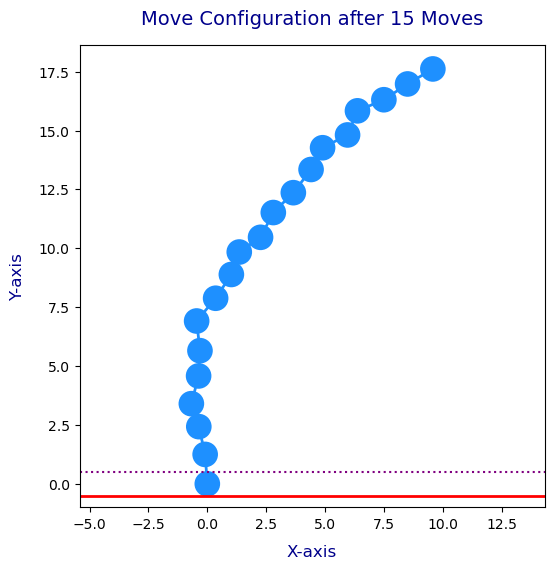

In [306]:
total_moves=15

configurations=np.zeros((total_moves, n_monomers, 2))
configurations[0]=monomers_initial_conf

for i in range(1,total_moves):
    configurations[i]=polymer_displacement(configurations[i-1])

conf=configurations[total_moves-1]

# Move plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='datalim')

for i, point in enumerate(conf):
    circle = plt.Circle((point[0], point[1]), 0.5, color='dodgerblue', alpha=1,linewidth=1.5)
    ax.add_patch(circle)
    if i > 0:
        prev_point = conf[i - 1]
        ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='dodgerblue', linewidth=2)

ax.set_xlim(min(p[0] for p in conf) - 1, max(p[0] for p in conf) + 1)
ax.set_ylim(min(p[1] for p in conf) - 1, max(p[1] for p in conf) + 1)
ax.axhline(y=-monomer_radius, color='red', linestyle='-', linewidth=2, label="Wall")
ax.axhline(y=energy_threshold, color='purple', linestyle=':', linewidth=1.5, label="Energy Threshold")
ax.set_xlabel("X-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_ylabel("Y-axis", fontsize=12, labelpad=10, color='darkblue')
ax.set_title(f"Move Configuration after {total_moves} Moves", fontsize=14, color='darkblue', pad=15)

plt.show()

## Thermalization process

We study in this paragraph, for a fixed $\beta$, the energy evolution, the end-end distance evolution and the height of the end evolution

In [307]:
@numba.njit(cache=True)
def end2end_distance_squared (configuration : np.ndarray) -> np.float64:
    return np.sqrt((configuration[-1][0]- configuration[0][0])**2+(configuration[-1][1]- configuration[0][1])**2)

@numba.njit(cache=True)
def energy (configuration : np.ndarray) -> np.float64:
    energy = 0
    for point in configuration:
        if point[1]<energy_threshold: energy-=epsilon_energy
    return energy

@numba.njit(cache=True)
def gyration_radius (configuration : np.ndarray) -> np.float64:
    total_sum = 0 
    for point in configuration:
        total_sum += point[0]**2 + point[1]**2
    return np.sqrt(total_sum / n_monomers)


@numba.njit(cache=True)
def metropolis (old_configuration : np.ndarray, new_configuration : np.ndarray, beta : float) -> bool:
    delta_Energy=energy(new_configuration)-energy(old_configuration)
    if delta_Energy <= 0: return True
    elif np.random.random() <= np.exp(- beta * delta_Energy ) : return True
    return False            

In [308]:
time_max=100000

@numba.njit
def thermalization(beta : np.float64) -> (np.ndarray,np.ndarray,np.ndarray) :
    moves=np.zeros((time_max, n_monomers, 2))
    moves[0]=monomers_initial_conf
    ee2=np.zeros((time_max))
    energy_list=np.zeros((time_max))
    end_heigth=np.zeros((time_max))
    gyr_radius_list = np.zeros((time_max))
    for i in range(1, time_max):
        moves[i] = polymer_displacement(moves[i-1])
        if not metropolis(moves[i-1],moves[i], beta): moves[i] = moves[i-1]
        ee2[i] = end2end_distance_squared(moves[i])
        end_heigth[i]=moves[i,n_monomers-1,1]
        energy_list[i]=energy(moves[i])
        gyr_radius_list[i] = gyration_radius(moves[i])
    return ee2, end_heigth, energy_list, gyr_radius_list

In [309]:
x=np.arange(0,time_max,1)

BETA_DOWN = 2
BETA_UP = 4.5
beta_list = np.linspace(0, BETA_DOWN, 10 * BETA_DOWN) 
beta_additional_1 = np.arange(BETA_DOWN + 0.5, BETA_UP, 0.5)
#beta_additional_2 = np.arange(3.0 + 0.2, 5, 0.2)
beta_list = np.sort(np.concatenate((beta_list, beta_additional_1) , axis=None)) 

#beta_list = np.load(os.path.join(file_path, f"beta_list.npy"))
#print(f"attuale lunghezza beta_list: {len(beta_list)}")

ee2_results = np.zeros((len(beta_list), time_max))
end_height_results = np.zeros((len(beta_list), time_max))
energy_evolution_results = np.zeros((len(beta_list), time_max))
gyr_radius_results = np.zeros((len(beta_list), time_max))

In [310]:
for k, beta in enumerate(beta_list):
    ee2_results[k], end_height_results[k], energy_evolution_results[k], gyr_radius_results[k] = thermalization(beta)
    print(f"siamo alla fine del {k+1}° beta")

siamo alla fine del 1° beta


SystemError: CPUDispatcher(<function thermalization at 0x71dc9b3e8540>) returned a result with an exception set

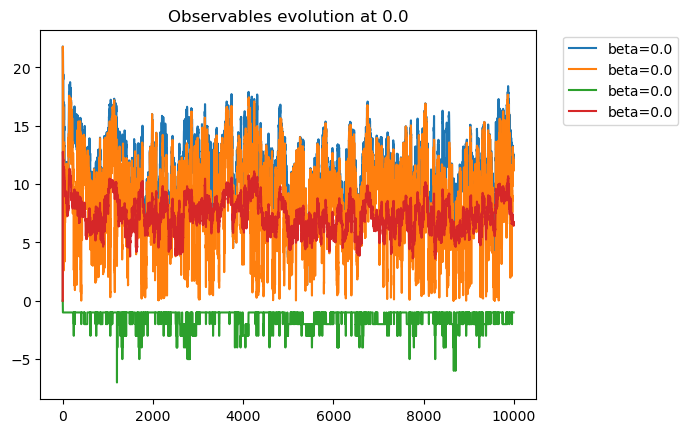

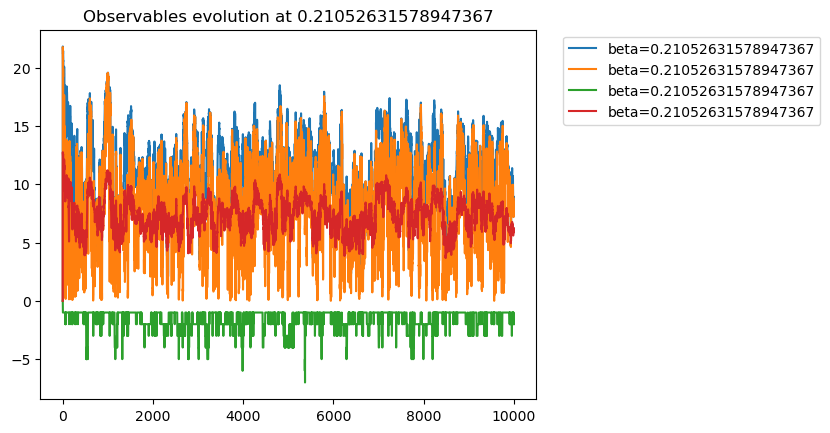

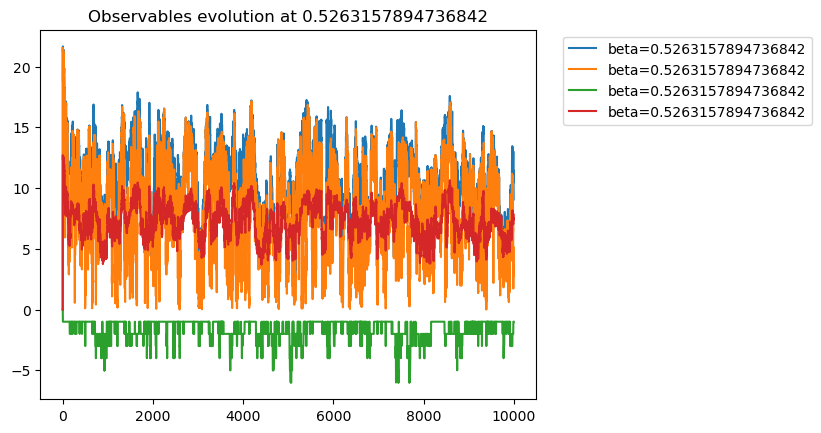

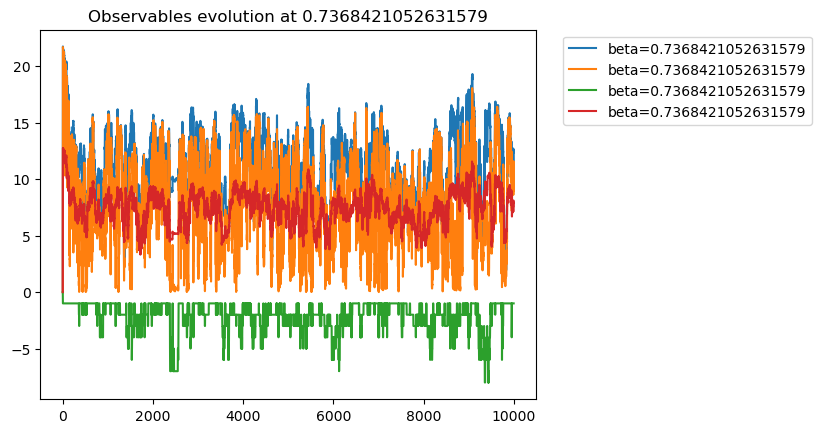

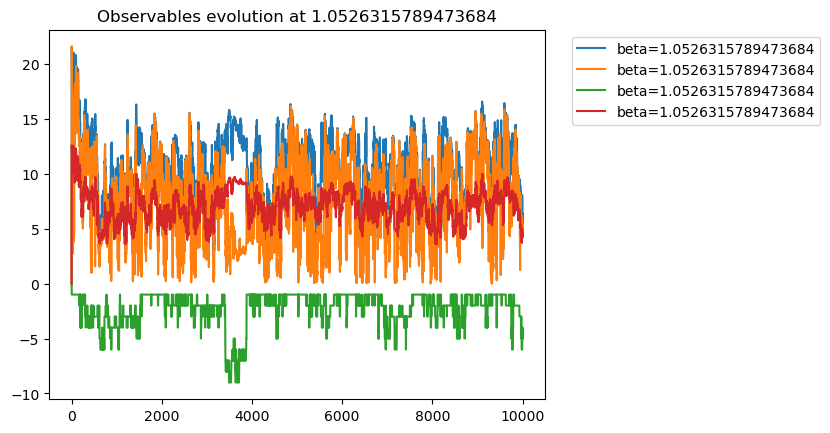

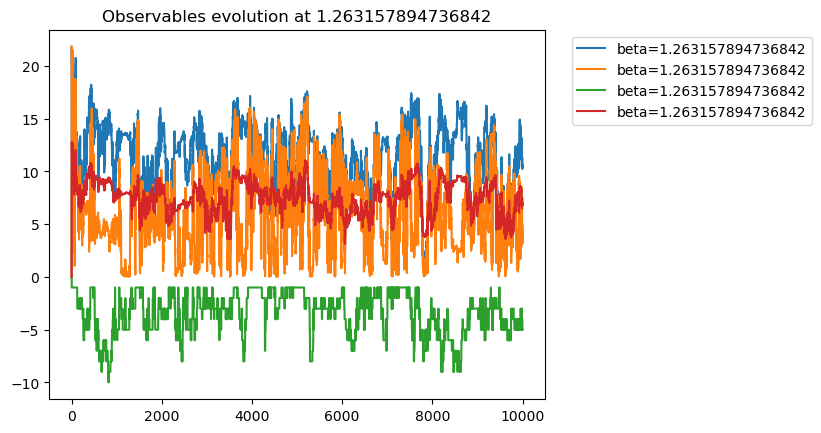

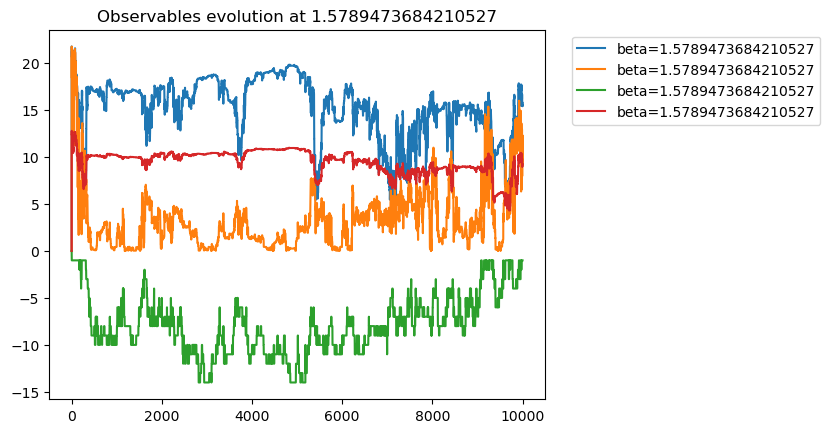

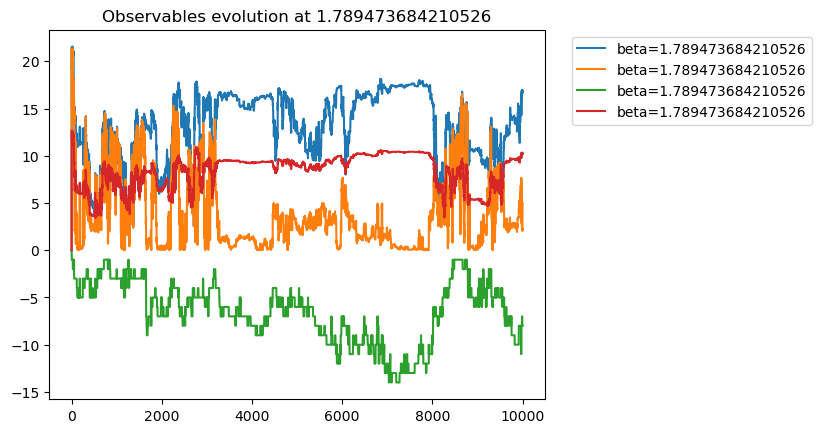

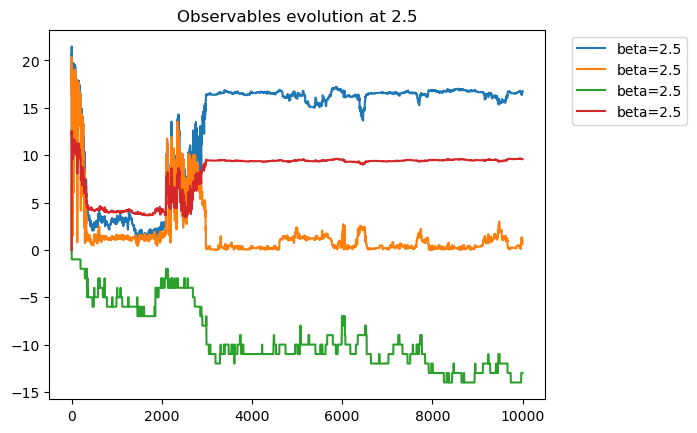

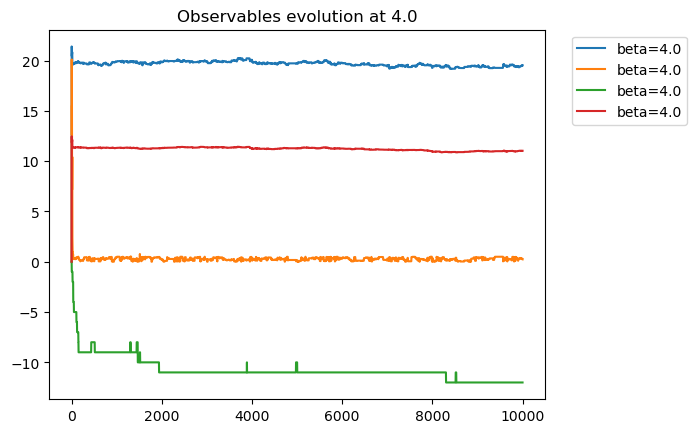

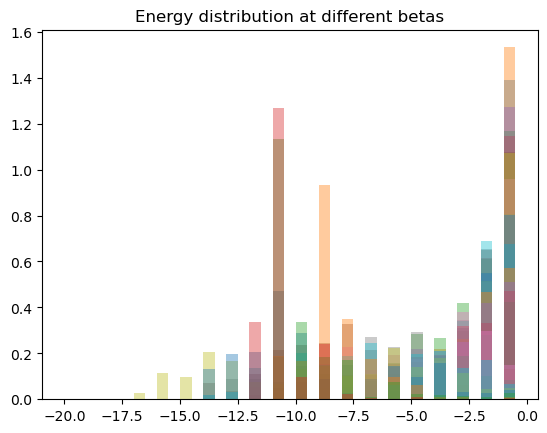

In [ ]:
selected_indices = np.linspace(0, len(beta_list) - 1, 10, dtype=int)
for i in selected_indices:
    plt.plot(x, ee2_results[i], label=f'beta={beta_list[i]}')
    plt.plot(x, end_height_results[i], label=f'beta={beta_list[i]}')
    plt.plot(x, energy_evolution_results[i], label=f'beta={beta_list[i]}')
    plt.plot(x, gyr_radius_results[i], label=f'beta={beta_list[i]}')
    plt.title(f"Observables evolution at {beta_list[i]}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

for i, beta in enumerate(beta_list):
    bins = np.arange(-n_monomers, 0, 0.5)
    plt.hist(energy_evolution_results[i], bins=bins, density=True, alpha=0.4,label=f'beta={beta_list[i]}')
plt.title(f"Energy distribution at different betas")
#plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [ ]:
energy_autocorr=np.zeros((len(beta_list), time_max))
end2end_autocorr=np.zeros((len(beta_list), time_max))
endheight_autocorr=np.zeros((len(beta_list), time_max))

for i, beta in enumerate(beta_list):
    energy_autocorr[i] = acf(energy_evolution_results[i],nlags=time_max)
    plt.plot(x,energy_autocorr[i], label=f"beta={beta}")

plt.title("Autocorrelation function for the energy at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.close() 

for i, beta in enumerate(beta_list):
    end2end_autocorr[i] = acf(ee2_results[i],nlags=time_max)
    plt.plot(x,end2end_autocorr[i], label=f"beta={beta}")

plt.title("Autocorrelation function for the end-to-end distance at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.close() 

for i, beta in enumerate(beta_list):
    endheight_autocorr[i] = acf(end_height_results[i],nlags=time_max)
    plt.plot(x,endheight_autocorr[i], label=f"beta={beta}")

plt.title("Autocorrelation function for the end height at different betas")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.close() 
    

In [ ]:
# We evaluate here the energy distribution intersection as a percentage

def dist_intersection_percentage(dist1, dist2):
    return np.sum(np.minimum(dist1, dist2))/(np.sum(dist1) + np.sum(dist2))

beta_additional = []

bins = np.arange(-n_monomers, 0, 0.5)
for i in range(1,len(beta_list)):
    hist1, _ = np.histogram(energy_evolution_results[i], bins=bins, density=True)
    hist2, _ = np.histogram(energy_evolution_results[i-1], bins=bins, density=True)
    overlap = dist_intersection_percentage(hist1, hist2)
    if (overlap * 100) < 10:
        additional_betas = np.linspace(beta_list[i-1], beta_list[i], 6)[1:-1]
        beta_additional.extend(additional_betas)      
    elif (overlap * 100) < 20:
        midpoint_beta = beta_list[i-1] + (beta_list[i] - beta_list[i-1]) / 2
        beta_additional.append(midpoint_beta)    
    print(f"Overlap between {beta_list[i-1]} and {beta_list[i]} of {overlap * 100} %")

if not beta_additional: print("PORCO PORCO PO")

beta_additional = np.array(beta_additional)
beta_list = np.sort(np.concatenate((beta_list, beta_additional), axis=None)) 
np.save(os.path.join(file_path, f"beta_list.npy"), beta_list)
print(f"{len(beta_list)}")

Overlap between 0.0 and 0.10526315789473684 of 46.439643964396446 %
Overlap between 0.10526315789473684 and 0.21052631578947367 of 40.92409240924093 %
Overlap between 0.21052631578947367 and 0.3157894736842105 of 49.12991299129913 %
Overlap between 0.3157894736842105 and 0.42105263157894735 of 46.724672467246734 %
Overlap between 0.42105263157894735 and 0.5263157894736842 of 45.02450245024502 %
Overlap between 0.5263157894736842 and 0.631578947368421 of 43.5993599359936 %
Overlap between 0.631578947368421 and 0.7368421052631579 of 44.91449144914491 %
Overlap between 0.7368421052631579 and 0.8421052631578947 of 42.489248924892486 %
Overlap between 0.8421052631578947 and 0.9473684210526315 of 39.95899589958996 %
Overlap between 0.9473684210526315 and 1.0526315789473684 of 44.41944194419442 %
Overlap between 1.0526315789473684 and 1.1578947368421053 of 40.96409640964096 %
Overlap between 1.1578947368421053 and 1.263157894736842 of 39.83398339833983 %
Overlap between 1.263157894736842 and 

gyration radius, while a perfect observable to indicate the system equilibrium, is misleading in this sytem to estimate the good/poor solvent limit. Is run dependent, the system can exhibit multiple poor solvent temperature in certain beta ranges (2+) according to where the last bead attaches to the absorbing wall

In [311]:
np.save(os.path.join(file_path, f"energy_series.npy"), energy_evolution_results)
np.save(os.path.join(file_path, f"ee2_series.npy"), ee2_results)
np.save(os.path.join(file_path, f"end2height_series.npy"),end_height_results)
np.save(os.path.join(file_path, f"gyr_radius_series.npy"), gyr_radius_results)